# Your notebook should begin with a project overview and goals and end with a conclusion that talks about your original goals and how you reached those (or didn't), the key findings, recommendations and next steps ("If I had more time, I would...")



# Planning

Business stakeholders and end users often ask more general questions that are very hard to answer directly or extremely specific questions that are not going to achieve their underlying goal. This leads to miscommunication, time spent on work that is ultimately thrown away, or inadequate understanding of the underlying problem being investigated. As you gain experience with the data and domain, you gain a better understanding of problems and can ask more informative & specialized questions. Even then, however, it is important to work through this planning stage, as it is all too easy to get lost down a rabbit hole when working on a data science project.

**The goal** of this stage is to clearly define your goal(s), measures of success, and plans on how to achieve that.

**The deliverable** is documentation of your goal, your measure of success, and how you plan on getting there. If you haven't clearly defined success, you will not know when you have achieved it.

**How to get there:** You can get there by answering questions about the final product & formulating or identifying any initial hypotheses (from you or others).

Common questions include:

- What will the end product look like?
- What format will it be in?
- Who will it be delivered to?
- How will it be used?
- How will I know I'm done?
- What is my MVP?
- How will I know it's good enough?

Formulating hypotheses
- Is attribute V1 related to attribute V2?
- Is the mean of target variable Y for subset A significantly different from that of subset B?


In [1]:

#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#ignore warnings
import warnings
warnings.filterwarnings('ignore')
#pipeline imports
import env

#stats imports
from scipy import stats
from scipy.stats import pearsonr, spearmanr

#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

#math import
from math import sqrt

#project library
from wrangle import get_zillow_data
from wrangle import remove_outliers
from wrangle import split_data
# from prepare import clean_data, get_hist, get_box, remove_outliers, train_validate_test_split
# from explore import explore_univariate, exp_bivariate_categorical, exp_bivariate_continuous, exp_multivariate, exp_bivariate_categorical
# from evaluate import scale_it, rfe, select_kbest, get_baseline, get_residuals, plot_residual, regression_errors, baseline_mean_errors, better_than_baseline
# from model import model_baseline, linear_regression, tweedieregressor, lassolars, polynomialregression, model_test, plot_test_residuals, plot_distributions


#Hypothesis alpha
alpha = .05

In [2]:
df = get_zillow_data()

In [3]:
df.head()


,bedrooms,bathrooms,square_feet,year,tax_of_property,tax_assessed_value_target,fips,zip_code,transaction_date
0,2.0,1.0,775.0,1952.0,1056.05,74118.0,6037.0,96338.0,2017-09-18
1,4.0,2.0,1497.0,1949.0,6793.40,557360.0,6037.0,96420.0,2017-09-18
2,3.0,2.0,1337.0,1956.0,5314.35,459600.0,6037.0,96161.0,2017-09-18
3,4.0,2.0,1631.0,2002.0,3294.29,262657.0,6037.0,96361.0,2017-09-18
4,3.0,3.0,1454.0,1989.0,2410.40,130027.0,6037.0,97318.0,2017-09-18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   52441 non-null  float64
 1   bathrooms                  52441 non-null  float64
 2   square_feet                52359 non-null  float64
 3   year                       52325 non-null  float64
 4   tax_of_property            52437 non-null  float64
 5   tax_assessed_value_target  52440 non-null  float64
 6   fips                       52441 non-null  float64
 7   zip_code                   52415 non-null  float64
 8   transaction_date           52441 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


## Note:
Data was retrived using SQL and the names of the columns

- bedroomcnt as bedrooms
- calculatedfinishedsquarefeet as square_feet
- yearbuilt as year
- taxamount as tax_of_property
- axvaluedollarcnt as tax_assessed_value_target
- fips as fips
- regionidzip as zip_code
- transactiondate as transaction_date

# Initial questions

- Does zipcode affect `tax_assessed_value_target` ---> x = zip_code
- Does the size of the house affect `tax_assessed_value_target` ---> x = square_feet
- Does the amount of bathrooms and bedrooms affect `tax_assessed_value_target` --> x = rooms_&_bathrooms (feature engeniering by adding rooms and bathrooms)
- 

In [5]:
df.shape

(52441, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   52441 non-null  float64
 1   bathrooms                  52441 non-null  float64
 2   square_feet                52359 non-null  float64
 3   year                       52325 non-null  float64
 4   tax_of_property            52437 non-null  float64
 5   tax_assessed_value_target  52440 non-null  float64
 6   fips                       52441 non-null  float64
 7   zip_code                   52415 non-null  float64
 8   transaction_date           52441 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [7]:
# convert treansaction_date to date object type
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   bedrooms                   52441 non-null  float64       
 1   bathrooms                  52441 non-null  float64       
 2   square_feet                52359 non-null  float64       
 3   year                       52325 non-null  float64       
 4   tax_of_property            52437 non-null  float64       
 5   tax_assessed_value_target  52440 non-null  float64       
 6   fips                       52441 non-null  float64       
 7   zip_code                   52415 non-null  float64       
 8   transaction_date           52441 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(8)
memory usage: 3.6 MB


In [9]:
# There are some null values
df.isnull().sum()

bedrooms                       0
bathrooms                      0
square_feet                   82
year                         116
tax_of_property                4
tax_assessed_value_target      1
fips                           0
zip_code                      26
transaction_date               0
dtype: int64

In [10]:
f'total records that contain null values {df.isnull().sum().sum()}'

'total records that contain null values 229'

In [11]:
# Create list of the names of the columsn 
df.columns.values

array(['bedrooms', 'bathrooms', 'square_feet', 'year', 'tax_of_property',
       'tax_assessed_value_target', 'fips', 'zip_code',
       'transaction_date'], dtype=object)

In [12]:
# Create value counts to see upper outliers
cols = df.columns.values
for col in cols:
    print(col.upper())
    print(df[col].value_counts(dropna=False,ascending=True).head(10))

BEDROOMS
14.0      1
11.0      1
10.0      2
12.0      3
9.0       8
8.0      24
7.0     106
0.0     137
1.0     612
6.0     635
Name: bedrooms, dtype: int64
BATHROOMS
13.0     1
18.0     1
11.0     3
8.5      3
10.0     5
9.0     13
7.5     16
6.5     47
8.0     53
7.0     88
Name: bathrooms, dtype: int64
SQUARE_FEET
4566.0     1
3103.0     1
11704.0    1
3861.0     1
4967.0     1
4780.0     1
4357.0     1
4203.0     1
7770.0     1
4536.0     1
Name: square_feet, dtype: int64
YEAR
1889.0    1
1880.0    1
1882.0    1
1897.0    1
1878.0    1
1892.0    1
1894.0    1
1893.0    3
2016.0    3
1887.0    3
Name: year, dtype: int64
TAX_OF_PROPERTY
1136.39     1
2818.02     1
3857.22     1
4871.52     1
15512.71    1
5838.96     1
9969.72     1
1602.96     1
19379.20    1
872.36      1
Name: tax_of_property, dtype: int64
TAX_ASSESSED_VALUE_TARGET
NaN          1
416775.0     1
358482.0     1
114633.0     1
1555151.0    1
1614974.0    1
382322.0     1
762655.0     1
296960.0     1
49636.0      1


In [13]:
# Create value counts to see lower end outliers
cols = df.columns.values
for col in cols:
    print(col.upper())
    print(df[col].value_counts(dropna=False,ascending=True).tail(30))

BEDROOMS
14.0        1
11.0        1
10.0        2
12.0        3
9.0         8
8.0        24
7.0       106
0.0       137
1.0       612
6.0       635
5.0      3973
2.0      8340
4.0     15240
3.0     23359
Name: bedrooms, dtype: int64
BATHROOMS
13.0        1
18.0        1
11.0        3
8.5         3
10.0        5
9.0        13
7.5        16
6.5        47
8.0        53
7.0        88
0.0       121
5.5       224
6.0       322
4.5       687
5.0       803
1.5       841
3.5       918
4.0      2227
2.5      3934
1.0      9568
3.0     10673
2.0     21893
Name: bathrooms, dtype: int64
SQUARE_FEET
1032.0     64
1242.0     65
1372.0     65
1288.0     66
1560.0     66
1540.0     67
864.0      67
1064.0     68
1008.0     69
1480.0     70
1536.0     70
1248.0     70
1320.0     71
1144.0     72
1240.0     73
1472.0     73
1260.0     73
1440.0     77
1296.0     78
1300.0     78
1570.0     79
NaN        82
1232.0     83
1400.0     83
1176.0     84
936.0      86
1040.0     86
1080.0    102
1200.0    119


In [14]:
df.fips.value_counts()

6037.0    33910
6059.0    14136
6111.0     4395
Name: fips, dtype: int64

## Takeaway 

- There are some null values. We will remove the those records 
    - 229 values
- I will drop year built as 
- Drop trasaction date as we won't be using it to predict our target value
- There are some ovious outliers that I will pull out before xpliting the data
    - Bedrooms (4 record)
        - 14
        - 11
        - 10
    - Bathrooms (4 records)
        - 13
        - 18
        - 8.5

In [15]:
print(df[df.bathrooms == 13])
print(df[df.bathrooms == 18])
print(df[df.bathrooms == 8.5])

       bedrooms  bathrooms  square_feet    year  tax_of_property  \
10862       7.0       13.0      20612.0  1994.0         149026.6   

       tax_assessed_value_target    fips  zip_code transaction_date  
10862                 12386870.0  6037.0   96086.0       2017-04-07  
       bedrooms  bathrooms  square_feet    year  tax_of_property  \
15643      14.0       18.0      18654.0  1927.0         586639.3   

       tax_assessed_value_target    fips  zip_code transaction_date  
15643                 49061236.0  6037.0   96058.0       2017-02-08  
       bedrooms  bathrooms  square_feet    year  tax_of_property  \
36707       7.0        8.5      11704.0  2004.0         75626.76   
45004       4.0        8.5       7424.0  2010.0         83518.94   
50245       6.0        8.5       9636.0     NaN         36259.12   

       tax_assessed_value_target    fips  zip_code transaction_date  
36707                  6572554.0  6059.0   96940.0       2017-04-28  
45004                  7491448.0 

In [16]:
# #~ means oposit-to-what the function is calling
df  = df[~df.index.isin([ 10862, 15643, 36707, 45004, 50245])]
df.shape

# #  bring all recors expet the 15649
# dfcopy[dfcopy.index != 15643]
# # rewrites the dataframe withot record
# dfcopy = dfcopy[dfcopy.index != 15643]



(52436, 9)

## Takeaway 

- There are some null values. We will remove the those records 
    - 229 values
- I will drop year built 
- Drop trasaction date as we won't be using it to predict our target value
- Drop houses that do not have a bathroom. Houses with 0 room can be studios or open floor layout
- Drop null values as they do not affect the size of our data significantly
- Drop houses smaller than 200 sqft



In [17]:
df.isnull().sum().sum()

228

In [18]:
# dropping nulls
df = df.dropna()
df.isnull().sum()

bedrooms                     0
bathrooms                    0
square_feet                  0
year                         0
tax_of_property              0
tax_assessed_value_target    0
fips                         0
zip_code                     0
transaction_date             0
dtype: int64

In [19]:
df.head(1)

,bedrooms,bathrooms,square_feet,year,tax_of_property,tax_assessed_value_target,fips,zip_code,transaction_date
0,2.0,1.0,775.0,1952.0,1056.05,74118.0,6037.0,96338.0,2017-09-18


In [20]:
# drop transaction date
df = df.drop(labels=["transaction_date"], axis=1)

In [21]:
df.head(1)

,bedrooms,bathrooms,square_feet,year,tax_of_property,tax_assessed_value_target,fips,zip_code
0,2.0,1.0,775.0,1952.0,1056.05,74118.0,6037.0,96338.0


In [22]:
df.shape

(52292, 8)

In [23]:
# Eliminate properties with 0 bathrooms 
# This eleminates 42 properties
df = df[(df.bathrooms != 0)]
df.shape
# houses with 0 bedrooms are normal as long as they have atleast one bathroom 

(52251, 8)

In [24]:
52292 - 52251

41

In [25]:
# Drop houses smaller than 200 
df = df[df['square_feet'] > 300]
df.shape

(52247, 8)

In [26]:
# Use z score to detect outliers
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis = 1)
df = df[filtered_entries]
df.shape

(50611, 8)

### change float to interger

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50611 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   50611 non-null  float64
 1   bathrooms                  50611 non-null  float64
 2   square_feet                50611 non-null  float64
 3   year                       50611 non-null  float64
 4   tax_of_property            50611 non-null  float64
 5   tax_assessed_value_target  50611 non-null  float64
 6   fips                       50611 non-null  float64
 7   zip_code                   50611 non-null  float64
dtypes: float64(8)
memory usage: 3.5 MB


In [28]:

df.year = df.year.astype(int)
df.fips = df.fips.astype(int)
df.zip_code = df.zip_code.astype(int)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50611 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bedrooms                   50611 non-null  float64
 1   bathrooms                  50611 non-null  float64
 2   square_feet                50611 non-null  float64
 3   year                       50611 non-null  int64  
 4   tax_of_property            50611 non-null  float64
 5   tax_assessed_value_target  50611 non-null  float64
 6   fips                       50611 non-null  int64  
 7   zip_code                   50611 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 3.5 MB


### visualize data

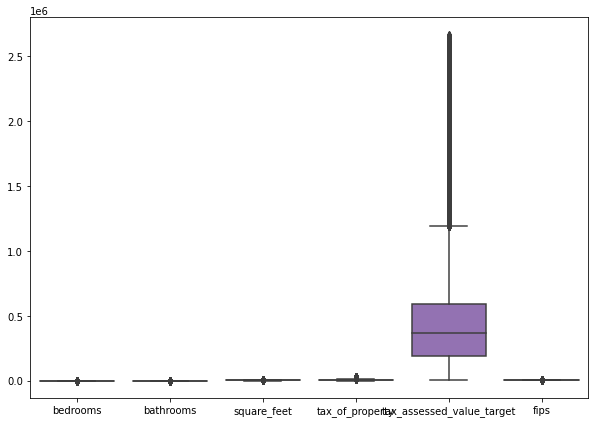

In [30]:
# We don't want to plot the `year` and `zip_code` columns.

plt.figure(figsize=(10,7))

# Create boxplots for all
sns.boxplot(data=df.drop(columns=['year', 'zip_code']))
plt.show()

In [31]:
df2 = df
df2.shape

(50611, 8)

In [32]:
df2 = remove_outliers(df, 1.5, ['bedrooms', 'bathrooms', 'square_feet', 'year', 'tax_of_property', 'tax_assessed_value_target', 'zip_code'])
df2.shape

(44472, 8)

In [33]:
50611 - 44472

6139

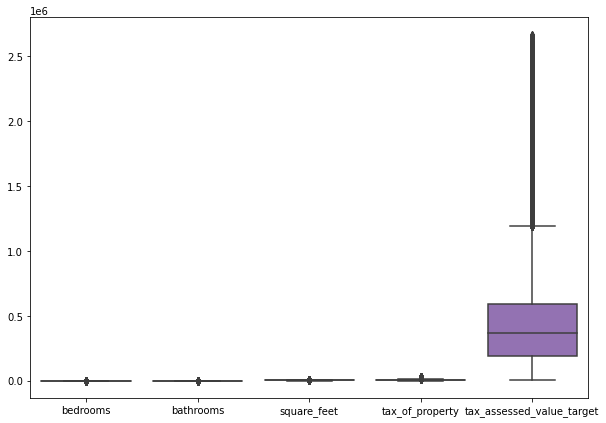

In [34]:
# We don't want to plot the `year` and `zip_code` columns.

plt.figure(figsize=(10,7))

# Create boxplots for all
sns.boxplot(data=df.drop(columns=['year', 'zip_code', 'fips']))
plt.show()

array([[<AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'square_feet'}>],
       [<AxesSubplot:title={'center':'year'}>,
        <AxesSubplot:title={'center':'tax_of_property'}>,
        <AxesSubplot:title={'center':'tax_assessed_value_target'}>],
       [<AxesSubplot:title={'center':'fips'}>,
        <AxesSubplot:title={'center':'zip_code'}>, <AxesSubplot:>]],
      dtype=object)

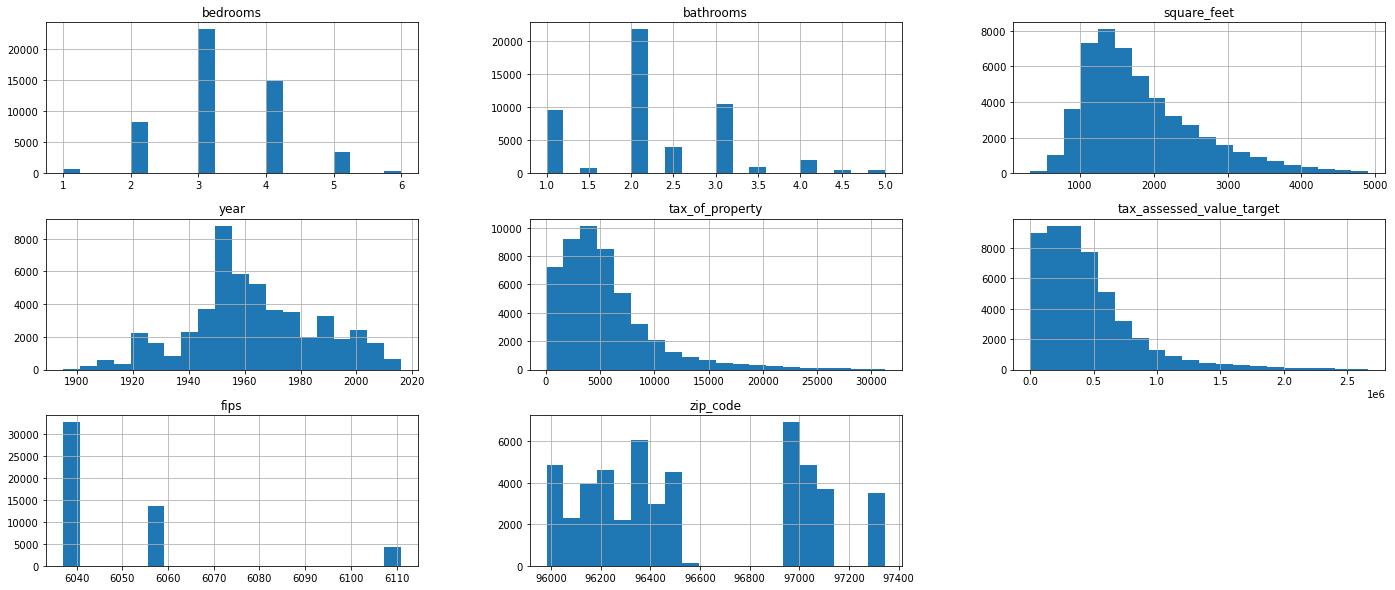

In [35]:
df.hist(figsize=(24, 10), bins=20)


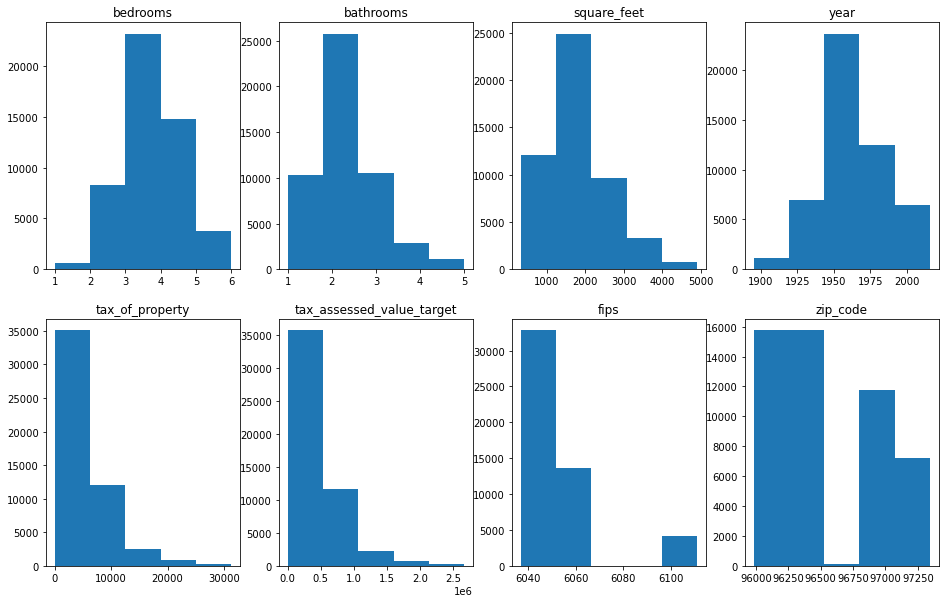

In [36]:
plt.figure(figsize=(16, 10))

# List of columns
cols = df.columns.values

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(2,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedrooms,50611.0,3.262552,0.880077,1.00,3.00,3.00,4.000,6.00
bathrooms,50611.0,2.216544,0.859171,1.00,2.00,2.00,3.000,5.00
square_feet,50611.0,1824.654067,772.181524,326.00,1257.00,1633.00,2230.000,4908.00
year,50611.0,1962.916164,22.679765,1895.00,1950.00,1960.00,1978.000,2016.00
tax_of_property,50611.0,5546.834440,4398.874602,49.18,2600.62,4531.16,7041.535,31261.97
tax_assessed_value_target,50611.0,451163.183023,380260.513565,1000.00,188411.50,363459.00,588501.500,2665031.00
fips,50611.0,6049.075162,20.994742,6037.00,6037.00,6037.00,6059.000,6111.00
zip_code,50611.0,96569.137520,421.169380,95982.00,96208.00,96415.00,96996.000,97344.00


Here is a histogram of the dataset we will be working with.


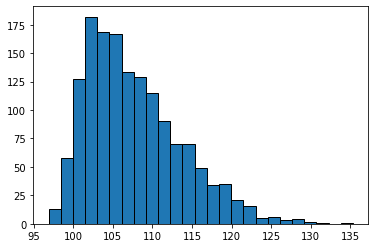

In [38]:
np.random.seed(123)

x = stats.skewnorm(7).rvs(1500) * 10 + 100
x = x.reshape(-1, 1)

plt.hist(x, bins=25, ec='black')
print('Here is a histogram of the dataset we will be working with.')

### For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product).

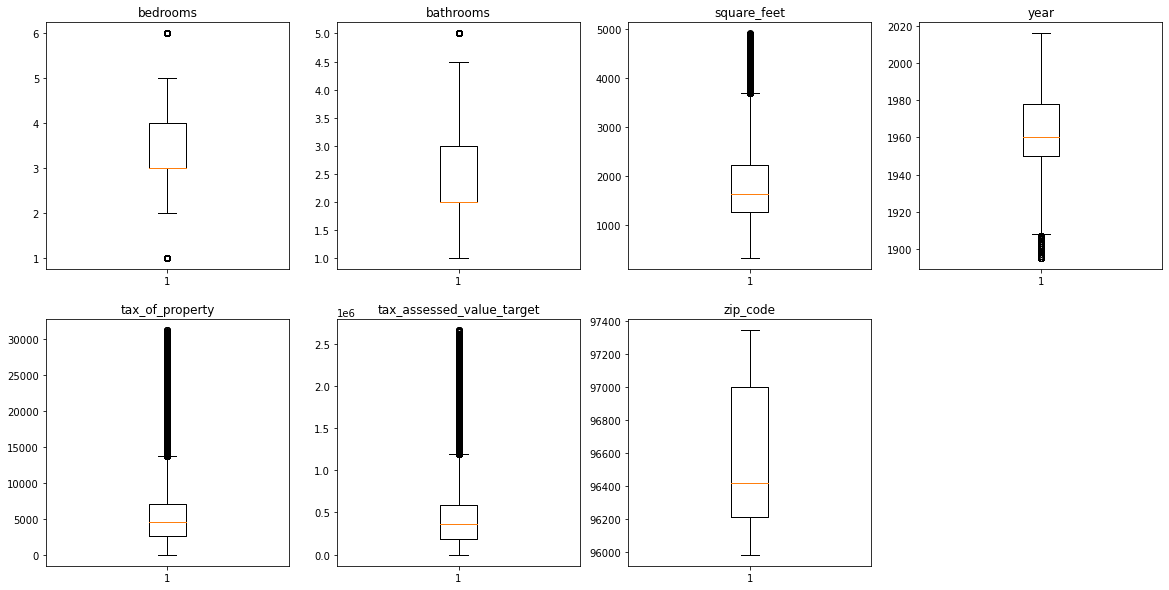

In [39]:
# List of columns
cols = ['bedrooms', 'bathrooms', 'square_feet', 'year', 'tax_of_property', 'tax_assessed_value_target', 'zip_code']


    
# loop for boxlots 
plt.figure(figsize=(20, 10))

for i, col in enumerate(cols):
    
    # start count at 
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(2,4, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    plt.boxplot(df[col])
    
  

# Split the Data

In [40]:
# Use split_data function from wrangle
train, validate, test = split_data(df)

In [41]:
train.shape, validate.shape, test.shape

((28341, 8), (12147, 8), (10123, 8))

# Scale the Data 

In [42]:
# Chose feaures to run
features = ['bedrooms', 'bathrooms', 'square_feet', 'year', 'fips', 'zip_code']
    

In [43]:
# Note that we only call .fit with the training data,
x_train = train[features]
x_validate = train[features]
x_test = train[features]

Text(0.5, 1.0, 'Scaled')

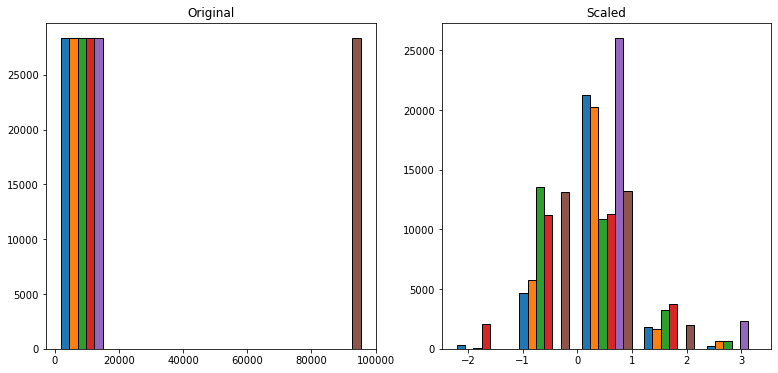

In [49]:
# RobustScaler

scaler = RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_validate_scaled = scaler.transform(x_validate)
x_test_scaled = scaler.transform(x_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(x_train, bins=5, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=5, ec='black')
plt.title('Scaled')

In [ ]:
robust_scaler(train, validate, test)